# FracAttitude

Jupyter Notebook for geological orientation analysis.

© 2024 Andrea Bistacchi, released under GNU AFFERO V.3 license.

## 1) Data import and reformatting.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplstereonet
import sphstat.singlesample
from mpmath.libmp.backend import sage_utils
from sklearn_extra.cluster import KMedoids
import sphstat.singlesample as ss_singlesample
import sphstat.utils as ss_utils

# initialize variables
rad = np.pi/180
deg = 180/np.pi

# import data and preview
# --- MODIFY THIS TO POINT TO YOUR DATA ---
data_lower = pd.read_csv('frac_attitude_data.csv')

# show dataframe
data_lower

,Dip,DipDir_
0,84.790794,47.249985
1,80.846962,39.596832
2,87.935318,38.538193
3,83.888390,211.480164
4,80.757980,222.549362
...,...,...
786,68.656250,135.923401
787,76.161148,122.535019
788,38.897453,135.679932
789,77.396797,118.034248


In [2]:
# rename columns
# --- MODIFY THIS ACCORDING TO YOUR DATA ---
data_lower.rename(columns={'DipDir_': 'dipdir', 'Dip': 'dip'}, inplace=True)

# create new polar coords columns
data_lower['plunge'] = 90 - data_lower['dip']
data_lower['trend'] = data_lower['dipdir'] + 180
data_lower['strike'] = (data_lower['dipdir'] - 90)

# reformat as 0-360°, cannot use modulo operator "%" directly due to precedence in arithmetic operations
data_lower['trend'] = data_lower['trend'] % 360
data_lower['strike'] = data_lower['strike'] % 360

# create new cartesian coords columns for pole
data_lower['l'] = np.cos(data_lower['plunge']*rad) * np.cos(data_lower['trend']*rad)
data_lower['m'] = np.cos(data_lower['plunge']*rad) * np.sin(data_lower['trend']*rad)
data_lower['n'] = -np.sin(data_lower['plunge']*rad)

# show dataframe
data_lower

,dip,dipdir,plunge,trend,strike,l,m,n
0,84.790794,47.249985,5.209206,227.249985,317.249985,-0.675997,-0.731289,-0.090793
1,80.846962,39.596832,9.153038,219.596832,309.596832,-0.760737,-0.629266,-0.159072
2,87.935318,38.538193,2.064682,218.538193,308.538193,-0.781685,-0.622632,-0.036028
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605
...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,0.669137,-0.647909,-0.363963
787,76.161148,122.535019,13.838852,302.535019,32.535019,0.522203,-0.818591,-0.239192
788,38.897453,135.679932,51.102547,315.679932,45.679932,0.449250,-0.438712,-0.778271
789,77.396797,118.034248,12.603203,298.034248,28.034248,0.458674,-0.861399,-0.218198


In [3]:
# duplicate data mirroring l,m,n cartesian poles in the upper hemisphere
data_upper = data_lower.copy()
data_upper['l'] = -data_upper['l']
data_upper['m'] = -data_upper['m']
data_upper['n'] = -data_upper['n']

# show dataframe
data_upper

,dip,dipdir,plunge,trend,strike,l,m,n
0,84.790794,47.249985,5.209206,227.249985,317.249985,0.675997,0.731289,0.090793
1,80.846962,39.596832,9.153038,219.596832,309.596832,0.760737,0.629266,0.159072
2,87.935318,38.538193,2.064682,218.538193,308.538193,0.781685,0.622632,0.036028
3,83.888390,211.480164,6.111610,31.480164,121.480164,-0.847974,-0.519235,0.106466
4,80.757980,222.549362,9.242020,42.549362,132.549362,-0.727132,-0.667447,0.160605
...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,-0.669137,0.647909,0.363963
787,76.161148,122.535019,13.838852,302.535019,32.535019,-0.522203,0.818591,0.239192
788,38.897453,135.679932,51.102547,315.679932,45.679932,-0.449250,0.438712,0.778271
789,77.396797,118.034248,12.603203,298.034248,28.034248,-0.458674,0.861399,0.218198


In [4]:
# concatenate data_lower and data_upper
data_both = pd.concat([data_lower, data_upper])

# show dataframe
data_both

,dip,dipdir,plunge,trend,strike,l,m,n
0,84.790794,47.249985,5.209206,227.249985,317.249985,-0.675997,-0.731289,-0.090793
1,80.846962,39.596832,9.153038,219.596832,309.596832,-0.760737,-0.629266,-0.159072
2,87.935318,38.538193,2.064682,218.538193,308.538193,-0.781685,-0.622632,-0.036028
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605
...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,-0.669137,0.647909,0.363963
787,76.161148,122.535019,13.838852,302.535019,32.535019,-0.522203,0.818591,0.239192
788,38.897453,135.679932,51.102547,315.679932,45.679932,-0.449250,0.438712,0.778271
789,77.396797,118.034248,12.603203,298.034248,28.034248,-0.458674,0.861399,0.218198


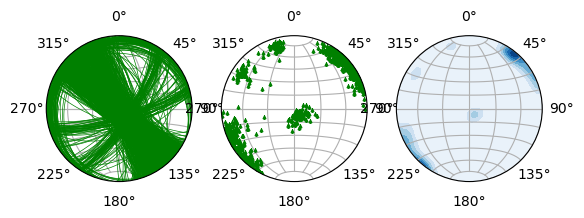

In [5]:
# plot stereonets
fig = plt.figure()
# great circles
ax_1 = fig.add_subplot(131, projection='stereonet')
ax_1.grid()
ax_1.plane(data_lower['strike'] , data_lower['dip'], 'g-', linewidth=.5)
# poles
ax_2 = fig.add_subplot(132, projection='stereonet')
ax_2.grid()
ax_2.line(data_lower['plunge'], data_lower['trend'] , 'g^', markersize=2)
# contours
ax_3 = fig.add_subplot(133, projection='stereonet')
cax = ax_3.density_contourf(data_lower['plunge'], data_lower['trend'] , measurement='lines', cmap='Blues')
ax_3.grid(True)

plt.show()

## 2) K-medoids clustering.

Specify medoid initialization method with optional init array-like of shape(n_clusters, n_features)
-‘random’ selects n_clusters elements from the dataset
-‘heuristic’ (default) picks the n_clusters points with the smallest sum distance to every other point
-‘k-medoids++’ follows an approach based on k-means++_, and in general, gives initial medoids which are more separated than those generated by the other methods
-‘build’ is a greedy initialization of the medoids used in the original PAM algorithm. Often ‘build’ is more efficient but slower than other initializations on big datasets and it is also very non-robust, if there are outliers in the dataset, use another initialization

Specify medoid method with method
-‘alternate’ (default) is faster
-‘pam’ is more accurate

In [6]:
# input number of clusters.
# --- MODIFY THIS ACCORDING TO YOUR DATA ---
n_clusters = 5

# run clustering
kmedoids = KMedoids(n_clusters=n_clusters*2, random_state=0, method='pam', init='k-medoids++').fit(data_both[['l', 'm', 'n']])

# write results in dataframe
data_both['cluster'] = kmedoids.labels_

# show results
print("medoids:\n", kmedoids.cluster_centers_)
print("data_both['cluster'].unique(): ", data_both['cluster'].unique())
data_both

medoids:
 [[-0.12551642  0.09353547 -0.98767239]
 [ 0.42263933  0.90539685  0.04040473]
 [-0.77238551 -0.6324452   0.05859777]
 [ 0.93594339 -0.29471191 -0.19275596]
 [ 0.12551642 -0.09353547  0.98767239]
 [-0.53253948  0.81024747  0.24474627]
 [-0.42263933 -0.90539685 -0.04040473]
 [ 0.53253948 -0.81024747 -0.24474627]
 [ 0.77238551  0.6324452  -0.05859777]
 [-0.93594339  0.29471191  0.19275596]]
data_both['cluster'].unique():  [2 8 1 6 0 7 3 4 5 9]


,dip,dipdir,plunge,trend,strike,l,m,n,cluster
0,84.790794,47.249985,5.209206,227.249985,317.249985,-0.675997,-0.731289,-0.090793,2
1,80.846962,39.596832,9.153038,219.596832,309.596832,-0.760737,-0.629266,-0.159072,2
2,87.935318,38.538193,2.064682,218.538193,308.538193,-0.781685,-0.622632,-0.036028,2
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466,8
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605,8
...,...,...,...,...,...,...,...,...,...
786,68.656250,135.923401,21.343750,315.923401,45.923401,-0.669137,0.647909,0.363963,5
787,76.161148,122.535019,13.838852,302.535019,32.535019,-0.522203,0.818591,0.239192,5
788,38.897453,135.679932,51.102547,315.679932,45.679932,-0.449250,0.438712,0.778271,5
789,77.396797,118.034248,12.603203,298.034248,28.034248,-0.458674,0.861399,0.218198,5


In [7]:
# keep clusters with medoid pointing downwards only
cluster_keep = (kmedoids.cluster_centers_[:,2] <= 0).nonzero()[0]
cluster_keep_centers = kmedoids.cluster_centers_[cluster_keep]
data_keep = data_both.loc[data_both['cluster'].isin(cluster_keep)]

# show results
print("cluster_keep: ", cluster_keep)
print("cluster_keep_centers:\n", cluster_keep_centers)
print("data_keep['cluster'].unique(): ", data_keep['cluster'].unique())
data_keep

cluster_keep:  [0 3 6 7 8]
cluster_keep_centers:
 [[-0.12551642  0.09353547 -0.98767239]
 [ 0.93594339 -0.29471191 -0.19275596]
 [-0.42263933 -0.90539685 -0.04040473]
 [ 0.53253948 -0.81024747 -0.24474627]
 [ 0.77238551  0.6324452  -0.05859777]]
data_keep['cluster'].unique():  [8 6 0 7 3]


,dip,dipdir,plunge,trend,strike,l,m,n,cluster
3,83.888390,211.480164,6.111610,31.480164,121.480164,0.847974,0.519235,-0.106466,8
4,80.757980,222.549362,9.242020,42.549362,132.549362,0.727132,0.667447,-0.160605,8
7,85.985756,222.469269,4.014244,42.469269,132.469269,0.735830,0.673538,-0.070004,8
9,89.945114,216.183426,0.054886,36.183426,126.183426,0.807131,0.590372,-0.000958,8
13,89.555504,221.108948,0.444496,41.108948,131.108948,0.753438,0.657473,-0.007758,8
...,...,...,...,...,...,...,...,...,...
598,84.594612,249.189407,5.405388,69.189407,159.189407,-0.353700,-0.930603,0.094202,6
604,89.193436,253.327789,0.806564,73.327789,163.327789,-0.286868,-0.957867,0.014077,6
605,87.624664,251.528275,2.375336,71.528275,161.528275,-0.316564,-0.947665,0.041446,6
606,73.788132,256.031799,16.211868,76.031799,166.031799,-0.231785,-0.931842,0.279190,6


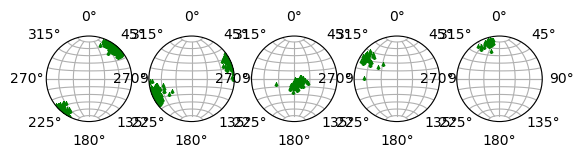

In [8]:
# plot clusters
# create empty figure
fig = plt.figure()
# initialize subplot indexes
n_subplots = 100 + n_clusters*10
# plot for each cluster
for cluster in data_keep['cluster'].unique():
    n_subplots += 1
    ax = fig.add_subplot(n_subplots, projection='stereonet')
    ax.grid()
    plunge = data_keep[data_keep['cluster'] == cluster]['plunge']
    trend = data_keep[data_keep['cluster'] == cluster]['trend']
    ax.line(plunge, trend, 'g^', markersize=2)

## 3) Descriptive stats and tests for each cluster with [SpheriStat singlesample module](https://sphstat.readthedocs.io/en/latest/sphstat.singlesample.html#).

__fisherparams__ returns a dictionary with keys:
- mdir: Mean direction (theta (colatitude), phi (longitude)) (tuple) (could be converted with ss_utils.poltodi())
- kappa: Concentration parameter (float)
- thetaalpha: Semivertical angle (float)
- cikappa: (kappalow, kappahigh) is the (1-alpha)% CI for kappa (tuple)

__kentparams__ returns:
- axes: Axes of the distribution (axes[0] is the mean direction) (could be converted with ss_utils.cart2sph() and ss_utils.poltodi())
- kappahat: Concentration parameter of the distribution (float)
- betahat: Ovalness parameter (float)

__kentmeanccone__ returns:
- cconept: 360 points on the (1-alpha)% cone of confidence (list)
- ths1: Major semi-axis (in radians)
- ths2: Minor semi-axis (in radians)

__isuniform__ tests if the sample comes from a uniform distribution [True] as opposed to a unimodal distribution [False], returns a dictionary with keys:
- teststat: Test statistic (float)
- crange: Critical range (float)
- testresult: Test result (bool)

__isfisher__ is a goodness-of-fit test of the data with the Fisher model ([True] if the Fisher model is acceptable), returns a dictionary with keys:
- 'colatitute': Results of the colatitude test as a nested dictionary ('stat': Test statistic (float), 'crange': Critical range (float), 'H0': Test result (bool))
- 'longitude': Results of the longitude test as a nested dictionary ('stat': Test statistic (float), 'crange': Critical range (float), 'H0': Test result (bool))
- 'twovariable': Results of the two-variable test as a nested dictionary ('stat': Test statistic (float), 'crange': Critical range (float), 'H0': Test result (bool))
- 'H0': All three tests retain H0 then True, otherwise false
- 'alpha': Type-I error level

__isfishervskent__ tests whether a sample comes from a Fisher distribution [True] against the alternative that it comes from a Kent distribution [False], returns a dictionary with keys:
- K: Test statistic (float)
- cval: Critical value (float)
- p: p-value (float)
- testresult: Test result (bool)

_All angles in the following are shown as degrees._

In [9]:
# loop for each cluster
for cluster in data_keep['cluster'].unique():
    print("\n\n-- cluster n.: ", cluster, " --")

    # format data for SpheriStat 'cart' (i.e. cartesian)
    samplecart = dict()
    samplecart['points'] = data_keep.loc[data_keep["cluster"] == cluster, ["l", "m", "n"]].to_numpy()
    samplecart['type'] = 'cart'
    samplecart['n'] = data_keep.loc[data_keep['cluster'] == cluster].shape[0]

    # estimate parametric distributions

    print("\n-> Fisher distribution parameters:")
    fisher_dist = ss_singlesample.fisherparams(samplecart=samplecart, alpha=0.05)
    th, ph = fisher_dist['mdir']
    inc, dec = ss_utils.poltodi(th, ph)
    print("mdir: ", fisher_dist['mdir'])
    print('theta (colatiude): ', th*deg)
    print('phi (longitude): ', ph*deg)
    print('inc: ', inc*deg)
    print('dec: ', dec*deg)
    print("kappa: ", fisher_dist['kappa'])
    print("thetalpha: ", fisher_dist['thetalpha'])
    print("cikappa: ", fisher_dist['cikappa'])

    print("\n-> Kent distribution parameters:")
    axes, kappahat, betahat = ss_singlesample.kentparams(samplecart=samplecart)
    th, ph = ss_utils.cart2sph(axes[0])
    inc, dec = ss_utils.poltodi(th, ph)
    print("axes: ", axes)
    print('theta (colatiude): ', th*deg)
    print('phi (longitude): ', ph*deg)
    print('inc: ', inc*deg)
    print('dec: ', dec*deg)
    print("kappahat: ", kappahat)
    print("betahat: ", betahat)

    print("\n-> Kent elliptical confidence cone for the mean direction:")
    cconept, ths1, ths2 = ss_singlesample.kentmeanccone(samplecart=samplecart)
    # print("cconept: ", cconept)
    print("ths1: ", ths1*deg)
    print("ths2: ", ths2*deg)

    # tests

    print("\n-> Is uniform [True] test:")
    uniform_test = ss_singlesample.isuniform(sample=samplecart, alpha=0.05)
    ss_utils.prettyprintdict(uniform_test)

    print("\n-> Is Fisher [True] test:")
    fisher_test = ss_singlesample.isfisher(samplecart=samplecart, alpha=0.05)
    ss_utils.prettyprintdict(fisher_test)

    print("\n-> Is Fisher [True] vs. Kent [False] test:")
    fisher_kent_test = ss_singlesample.isfishervskent(samplecart=samplecart, alpha=0.05)
    ss_utils.prettyprintdict(fisher_kent_test)



-- cluster n.:  8  --

-> Fisher distribution parameters:
mdir:  (1.63243057271516, 0.6980858865514576)
theta (colatiude):  93.5313821647025
phi (longitude):  39.997375037046915
inc:  3.5313821647025083
dec:  320.00262496295306
kappa:  64.7256013668974
thetalpha:  0.016425188238783656
cikappa:  (57.95588913833671, 71.47575140579194)

-> Kent distribution parameters:
axes:  [array([ 0.76461928,  0.64153206, -0.06159523]), array([-0.62295532,  0.71120124, -0.32575982]), array([ 0.16517876, -0.28745331, -0.94344399])]
theta (colatiude):  93.5313821647025
phi (longitude):  39.997375037046915
inc:  3.5313821647025083
dec:  320.00262496295306
kappahat:  65.72547647296193
betahat:  4.053309381220005

-> Kent elliptical confidence cone for the mean direction:
ths1:  2.755318662156749
ths2:  1.8928359246995945

-> Is uniform [True] test:
teststat:  1020.7139914136229
crange:  7.814727903251179
testresult:  False

-> Is Fisher [True] test:
colatitute:  {'stat': 0.716891130661949, 'crange': 1.0

C:\Users\bistek\anaconda3\envs\fracattitude\Lib\site-packages\sphstat\singlesample.py:773: RuntimeWarning: invalid value encountered in arcsin
  ths1 = np.arcsin(s1)
C:\Users\bistek\anaconda3\envs\fracattitude\Lib\site-packages\sphstat\singlesample.py:774: RuntimeWarning: invalid value encountered in arcsin
  ths2 = np.arcsin(s2)
C:\Users\bistek\anaconda3\envs\fracattitude\Lib\site-packages\sphstat\singlesample.py:779: RuntimeWarning: invalid value encountered in sqrt
  w0 = np.sqrt(1 - u0**2 - v0**2)
